In [1]:
import pandas as pd
import cv2
import numpy as np
import glob
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

set_matplotlib_formats('svg')  # 展示的图片格式

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Resize, Normalize,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, ElasticTransform
)
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

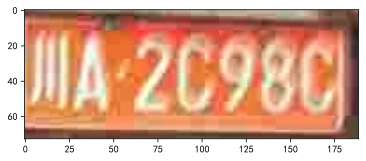

In [2]:
img = cv2.imread('./机动车车牌识别挑战赛公开数据/train/川A2C98C.jpg')
plt.imshow(img)

In [3]:
paths = glob.glob('./机动车车牌识别挑战赛公开数据/train/*')
labls = [x.split('/')[-1][:-4] for x in paths]

In [4]:
''.join(set(''.join(labls)))

'H5T贵B辽9赣闽C0YFGL蒙津7新J沪鲁8鄂浙X吉甘渝6S3U晋川陕VE皖黑粤WR冀A2QK豫D桂云1青P京4苏M湘NZ'

In [5]:
pd.DataFrame([x[0] for x in labls]).value_counts()

皖    19526
苏      462
浙      196
沪      103
鄂       78
豫       78
粤       76
鲁       74
京       67
赣       53
闽       43
陕       43
湘       38
冀       33
川       32
渝       27
晋       24
津       24
辽       19
黑        7
云        6
甘        5
蒙        4
贵        3
新        3
桂        2
吉        2
青        1
dtype: int64

In [6]:
pd.DataFrame([x[1] for x in labls]).value_counts()

A    18606
N      291
B      248
D      217
C      206
H      205
E      200
K      160
S      145
M      125
F      118
G      101
L       98
Q       95
J       76
P       69
R       53
Y        7
X        5
T        3
V        1
dtype: int64

In [7]:
len(''.join(list(set(''.join(labls)))))

62

In [8]:
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import time
import datetime
import pdb
import traceback

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [9]:
class QRDataset(Dataset):
    def __init__(self, img_paths, lbl_dict, transform=None, label=True):
        self.img_paths = img_paths
        self.lbl_dict = lbl_dict
        self.label = label

        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        start_time = time.time()

        img = cv2.imread(self.img_paths[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        img_label = self.img_paths[index].split('/')[-1][:-4]
        
        if self.label:
            label0 = np.array(self.char2idx(img_label[0]))
            label1 = np.array(self.char2idx(img_label[1]))
            label2 = np.array(self.char2idx(img_label[2]))
            label3 = np.array(self.char2idx(img_label[3]))
            label4 = np.array(self.char2idx(img_label[4]))
            label5 = np.array(self.char2idx(img_label[5]))
            label6 = np.array(self.char2idx(img_label[6]))

            return img, torch.from_numpy(label0), torch.from_numpy(label1), \
                torch.from_numpy(label2), torch.from_numpy(label3), torch.from_numpy(label4),\
                torch.from_numpy(label5), torch.from_numpy(label6)
        else:
            return img

    def __len__(self):
        return len(self.img_paths)

    def char2idx(self, ch):
        return self.lbl_dict.find(ch)

In [10]:
class RMB_Net(nn.Module):
    def __init__(self):
        super(RMB_Net, self).__init__()

        feat_size = 512
        self.fc0 = nn.Linear(feat_size, 62)
        self.fc1 = nn.Linear(feat_size, 62)
        self.fc2 = nn.Linear(feat_size, 62)
        self.fc3 = nn.Linear(feat_size, 62)
        self.fc4 = nn.Linear(feat_size, 62)
        self.fc5 = nn.Linear(feat_size, 62)
        self.fc6 = nn.Linear(feat_size, 62)

        model = models.resnet18(True)
        model = torch.nn.Sequential(*(list(model.children())[:-1]))
        self.resnet = model

        self.resnet = model

    def forward(self, img):
        feat = self.resnet(img)
        feat = feat.reshape(feat.size(0), -1)

        out0 = self.fc0(feat)
        out1 = self.fc1(feat)
        out2 = self.fc2(feat)
        out3 = self.fc3(feat)
        out4 = self.fc4(feat)
        out5 = self.fc5(feat)
        out6 = self.fc6(feat)

        return out0, out1, out2, out3, out4, out5, out6

In [11]:
train_loader = torch.utils.data.DataLoader(QRDataset(paths[:-500], 
                    'N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M',
      Compose([
                Resize(70, 200),
                GridDistortion(p=.5, distort_limit=0.15, num_steps=5),
                RandomBrightnessContrast(),
                ElasticTransform(alpha=0.1, sigma=5, alpha_affine=2,),
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ToTensorV2(),
        ])),
        batch_size=16, shuffle=True
)

val_loader = torch.utils.data.DataLoader(QRDataset(paths[-500:],
                    'N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M',
      Compose([
                Resize(70, 200),
                GridDistortion(p=.5, distort_limit=0.15, num_steps=5),
                RandomBrightnessContrast(),
                ElasticTransform(alpha=0.1, sigma=5, alpha_affine=2,),
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ToTensorV2(),
        ])),
        batch_size=16, shuffle=True
)

In [12]:
def accuracy(outputs, targets):
    with torch.no_grad():
        batch_size = outputs[0].size(0)
        
        output_idx = []
        for output in outputs:
            _, pred = output.topk(1, 1, True, True)
            # pred = pred
            pred = pred.t().flatten()
            output_idx.append(pred.data.cpu().numpy())
        
        output_idx = np.vstack(output_idx)
        targets = [x.data.cpu().numpy() for x in targets]
        targets = np.vstack(targets)
        return ((targets == output_idx).mean(0) == 1).mean(), (targets == output_idx).mean(0) != 1

def train(train_loader, model, criterion, optimizer):
    model.train()

    train_acc = []
    train_losss = []
    for input,target0,target1,target2,target3,target4,target5,target6 in tqdm(train_loader):
        optimizer.zero_grad()

        input = input.cuda(non_blocking=True)
        target0 = target0.cuda(non_blocking=True)
        target1 = target1.cuda(non_blocking=True)
        target2 = target2.cuda(non_blocking=True)
        target3 = target3.cuda(non_blocking=True)
        target4 = target4.cuda(non_blocking=True)
        target5 = target5.cuda(non_blocking=True)
        target6 = target6.cuda(non_blocking=True)

        # compute output
        output0,output1,output2,output3,output4,output5,output6 = model(input)
        loss0 = criterion(output0, target0)
        loss1 = criterion(output1, target1)
        loss2 = criterion(output2, target2)
        loss3 = criterion(output3, target3)
        loss4 = criterion(output4, target4)
        loss5 = criterion(output5, target5)
        loss6 = criterion(output6, target6)

        loss = (loss0+loss1+loss2+loss3+loss4+loss5+loss6)/7.0
        loss.backward()
        optimizer.step()
        train_losss.append(loss.item())
        
    return np.mean(train_losss)

def validate(val_loader, model, criterion):
    model.eval()
    
    val_acc = []
    val_loss = []
    val_error_idx = []
    val_prob = []
    with torch.no_grad():
        for i, (input,target0,target1,target2,target3,target4,target5,target6) in enumerate(val_loader):
            input = input.cuda(non_blocking=True)
            target0 = target0.cuda(non_blocking=True)
            target1 = target1.cuda(non_blocking=True)
            target2 = target2.cuda(non_blocking=True)
            target3 = target3.cuda(non_blocking=True)
            target4 = target4.cuda(non_blocking=True)
            target5 = target5.cuda(non_blocking=True)
            target6 = target6.cuda(non_blocking=True)
            
            # compute output
            output0,output1,output2,output3,output4,output5,output6 = model(input)
            loss0 = criterion(output0, target0)
            loss1 = criterion(output1, target1)
            loss2 = criterion(output2, target2)
            loss3 = criterion(output3, target3)
            loss4 = criterion(output4, target4)
            loss5 = criterion(output5, target5)
            loss6 = criterion(output6, target6)
            
            loss = (loss0+loss1+loss2+loss3+loss4+loss5+loss6)/10.0
            # measure accuracy and record loss
            acc, error_idx = accuracy([output0,output1,output2,output3,output4,output5,output6], 
                            [target0,target1,target2,target3,target4,target5,target6])
            
            output_prob = None
            for output in [output0,output1,output2,output3,output4,output5,output6]:
                if output_prob is None:
                    output_prob = np.exp(output.max(1)[0].data.cpu().numpy())
                else:
                    output_prob += np.exp(output.max(1)[0].data.cpu().numpy())
            output_prob /= 7.0
            
            val_acc.append(acc)
            val_loss.append(loss.item())
            val_error_idx += list(error_idx)
            val_prob += list(output_prob)


        return np.mean(val_acc), np.mean(val_loss)
        
        
def predict(test_loader, model):
    model.eval()

    test_prob = []
    with torch.no_grad():
        for i, input in enumerate(test_loader):
            input = input.cuda(non_blocking=True)
            
            # compute output
            output0,output1,output2,output3,output4,output5,output6 = model(input)
            
            output0 = output0.argmax(1).data.cpu().numpy()
            output1 = output1.argmax(1).data.cpu().numpy()
            output2 = output2.argmax(1).data.cpu().numpy()
            output3 = output3.argmax(1).data.cpu().numpy()
            output4 = output4.argmax(1).data.cpu().numpy()
            output5 = output5.argmax(1).data.cpu().numpy()
            output6 = output6.argmax(1).data.cpu().numpy()
            
            test_prob.append(
                np.vstack([output0,output1,output2,output3,output4,output5,output6]).T
            )

    return test_prob
        

In [13]:
model = RMB_Net()
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [14]:
for _ in range(5):
    train_loss = train(train_loader, model, criterion, optimizer)
    val_acc, val_loss = validate(val_loader, model, criterion)
    print('{:2f} {:2f} {:2f}'.format(train_loss, val_acc, val_loss))

  0%|          | 0/1284 [00:00<?, ?it/s]

1.195415 0.398438 0.355179


  0%|          | 0/1284 [00:00<?, ?it/s]

0.370024 0.689453 0.179101


  0%|          | 0/1284 [00:00<?, ?it/s]

0.226887 0.761719 0.136990


  0%|          | 0/1284 [00:00<?, ?it/s]

0.180660 0.779297 0.129675


  0%|          | 0/1284 [00:00<?, ?it/s]

0.151531 0.791016 0.110086


In [ ]:
test_paths = glob.glob('./机动车车牌识别挑战赛公开数据/test/*')
test_paths.sort()

test_loader = torch.utils.data.DataLoader(QRDataset(test_paths,
                    '0N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M',
      Compose([
                Resize(70, 200),
                GridDistortion(p=.5, distort_limit=0.15, num_steps=5),
                RandomBrightnessContrast(),
                ElasticTransform(alpha=0.1, sigma=5, alpha_affine=2,),
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ToTensorV2(),
        ]), False),
        batch_size=16, shuffle=False
)

test_pred = predict(test_loader, model)
test_pred = np.vstack(test_pred)

In [ ]:
test_texts = []
for ts in test_pred[:]:
    ts_text = ''
    for x in ts:
        ts_text += 'N鄂CD4云HSL湘渝5B苏贵浙TE晋P津X陕J青鲁K赣8辽FQ6R甘蒙G沪A冀吉新V9W1Y桂0黑闽豫Z粤京3川U72皖M'[x]
    
    test_texts.append(ts_text)

In [ ]:
pd.DataFrame([
    [x.split('/')[-1] for x in test_paths],
    test_texts
]).T.to_csv('submit.csv', index=None, header=None)

In [67]:
len(test_texts), len(test_paths)

(500, 5000)